In [1]:
'''
Import the modules that will be used
'''

import sys
sys.path.append('/home/cjw/Code/DeepLearning')
import warnings
from distutils.version import LooseVersion

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from autoencoder import network
from autoencoder import utils

%matplotlib inline

In [4]:
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()

datadir =  '/media/cjw/Data/cyto/mmFromTifs3/'
#datadir =  '/media/cjw/Data/cyto/ChannelOne/'

#cp_dir = '/home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-19-11-19-18/'
cp_dir ="/media/cjw/Data/cyto/Checkpoints/Cytometry/2018-04-17-Ch0-32-mmFromTifs3/checkpoint-2018-04-17-12-27-39/"
aemeta = 'autoencoder-64x-13980.meta'
#checkpoint-2018-03-02-16-31-42/'
p_width = 32
p_height = 32
p_nchannels = 1
p_channels = [0]
p_nepochs = 60
p_batchsize = 128
p_learning_rate = 0.0002  #.00005
p_restore = False
p_latent_size = 64 #128 + 64
p_droprate = 0.95
p_stdev = .04

enc_sizes = [(64, 3), (128, 3), (256,3)] #, (512,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
dec_sizes = list(reversed(enc_sizes))
images = tf.placeholder(tf.float32, (None, p_height, p_width, p_nchannels))
z = tf.placeholder(tf.float32, (None, p_latent_size))

enc = network.encoder(images, p_latent_size, droprate=p_droprate, is_train=False,
                      nfilters=enc_sizes)
sdd = network.decoder(enc, nchannels=p_nchannels, width=p_width, droprate=p_droprate,
                      is_train=False, nfilters=dec_sizes)

loss, _, _ = network.ae_loss(images, sdd)

opt = network.model_opt(loss, p_learning_rate)

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + aemeta) #autoencoder-64x-18660.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))


Encoder False
[<tf.Tensor 'Placeholder:0' shape=(?, 32, 32, 1) dtype=float32>, <tf.Tensor 'Maximum:0' shape=(?, 16, 16, 64) dtype=float32>, <tf.Tensor 'Maximum_1:0' shape=(?, 8, 8, 128) dtype=float32>, <tf.Tensor 'Maximum_2:0' shape=(?, 4, 4, 256) dtype=float32>] Tensor("latent_space/BiasAdd:0", shape=(?, 64), dtype=float32)
isize:  4 32
dh0 (?, 32, 32, 1)
[<tf.Tensor 'Maximum_3:0' shape=(?, 4096) dtype=float32>, <tf.Tensor 'Reshape:0' shape=(?, 4, 4, 256) dtype=float32>, <tf.Tensor 'Maximum_4:0' shape=(?, 8, 8, 128) dtype=float32>, <tf.Tensor 'Maximum_5:0' shape=(?, 16, 16, 64) dtype=float32>] Tensor("Minimum:0", shape=(?, 32, 32, 1), dtype=float32)
Tensor("Mean_1:0", shape=(), dtype=float32) Tensor("Mean_2:0", shape=(), dtype=float32) Tensor("add_5:0", shape=(), dtype=float32)
INFO:tensorflow:Restoring parameters from /media/cjw/Data/cyto/Checkpoints/Cytometry/2018-04-17-Ch0-32-mmFromTifs3/checkpoint-2018-04-17-12-27-39/autoencoder-64x-13980


In [5]:

#datadir = "/home/cjw/disk2cjw/Data/yeast/"
mmfiles = utils.list_mmfiles(datadir)
print(mmfiles)

mmdict = dict()

n_all_images = 0
for mmfilename in mmfiles:
#mmfilename = datadir + "Fish6_15_cjw_mean_zero.mm"
#mmfilename = datadir + "mmplate15-1.mm"
    mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

    header_shape = mmheader.shape
    print(header_shape, mmheader)
    xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
    xshape = tuple(xshape)
    del mmheader
    n_all_images += xshape[0]
    
    m3 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)
    key = mmfilename.split("/")[-1]
    mmdict[key] = m3

print(n_all_images)
mmdict.keys()

['/media/cjw/Data/cyto/mmFromTifs3/Fish6_Untreated.mm', '/media/cjw/Data/cyto/mmFromTifs3/Fish6_ICE.mm', '/media/cjw/Data/cyto/mmFromTifs3/Fish6_CCB.mm']
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
(4,) [10000    64    64     5]
30000


dict_keys(['Fish6_Untreated.mm', 'Fish6_ICE.mm', 'Fish6_CCB.mm'])

In [202]:
n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
for key in mmdict.keys():
    mm = mmdict[key]
    n = mm.shape[0]
    #print(n)
    file = n*[key[0:-3]]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)

trts = list()
runs = list()
alldf = pd.concat(dataframes, ignore_index=True)

for row in range(len(alldf)):
    file = alldf.iloc[row]['file']
    if '_ice' in file.lower():
        treatment = 'ice'
    elif '_ccb'in file.lower():
        treatment = 'ccb'
    else:
        treatment = "untreated"
    trts.append(treatment)
    runs.append(file[0:5])

alldf['treatment'] = trts
alldf['run'] = runs
df = alldf.sample(frac=1)
df = df.reset_index()
print(len(df))
df.tail()

30000


index  column   fid  field             file     id              mmfile  \
29995  22150       0  2150      0        Fish6_CCB  22150        Fish6_CCB.mm   
29996  29864       0  9864      0        Fish6_CCB  29864        Fish6_CCB.mm   
29997    669       0   669      0  Fish6_Untreated    669  Fish6_Untreated.mm   
29998   5005       0  5005      0  Fish6_Untreated   5005  Fish6_Untreated.mm   
29999  11161       0  1161      0        Fish6_ICE  11161        Fish6_ICE.mm   

       plate  row  well  xc  yc  treatment    run  
29995      0    0     0  32  32        ccb  Fish6  
29996      0    0     0  32  32        ccb  Fish6  
29997      0    0     0  32  32  untreated  Fish6  
29998      0    0     0  32  32  untreated  Fish6  
29999      0    0     0  32  32        ice  Fish6

In [203]:
sns.set_style("whitegrid", {'axes.grid' : False})

In [204]:
list(mmdict.keys())[0]

'Fish6_Untreated.mm'

In [205]:
m1 = mmdict[list(mmdict.keys())[0]]

bx = m1[34,:,:,0]
bx = np.expand_dims(bx, axis=0)
bx = np.expand_dims(bx, axis=-1)
bx.shape
bxe = sess.run(enc, feed_dict={images:bx})
#plt.plot(bxe[0])
bxd = sess.run(sdd, feed_dict={enc:bxe})
plt.imshow(bxd.squeeze())
print(np.mean(bxd),np.max(bxd))

ValueError: Cannot feed value of shape (1, 64, 64, 1) for Tensor 'Placeholder:0', which has shape '(?, 32, 32, 1)'

(30000, 64) (30000, 32, 32, 1)
0.0547319985926 0.934446513653


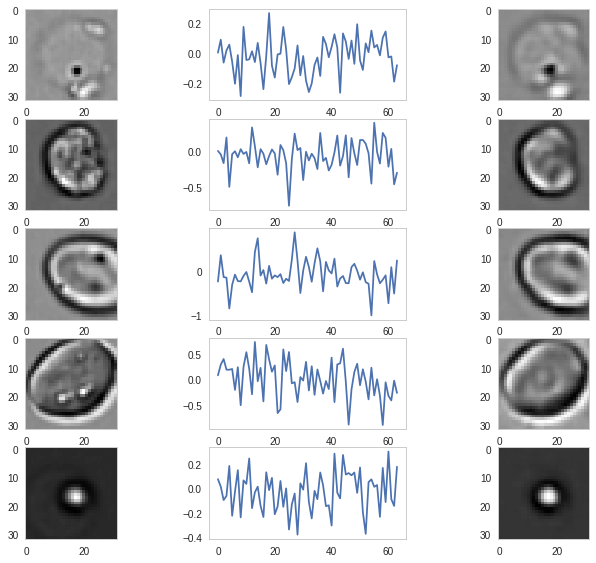

In [206]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, p_width, 0, 0, p_nchannels, channels=p_channels)

nvv = len(vv)
offloc = 0
offstep = 1000
offnext = offloc + offstep
xhe = np.zeros((nvv, p_latent_size))
xdd = np.zeros((nvv, p_width, p_height, p_nchannels))
while offloc < nvv:
    #print(offloc, offnext)
    xhe[offloc:offnext] = sess.run(enc, feed_dict={images:vv[offloc:offnext]})
    xdd[offloc:offnext] = sess.run(sdd, feed_dict={enc:xhe[offloc:offnext]})
    offloc = offnext
    offnext += offstep
    if offnext > nvv:
        offnext = nvv
        
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
for i in range(5):
    ix = np.random.randint(0, len(vv))
    #print(ix)
    plt.subplot(20,3,i*3 + 1)
    plt.imshow(vv[ix,:,:,0], cmap='gray')
    plt.subplot(20,3,i*3 + 2)
    plt.plot(xhe[ix])
    plt.subplot(20,3,i*3 + 3)
    plt.imshow(xdd[ix,:,:,0], cmap='gray')
   

In [207]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = xhe #sess.run(enc, feed_dict={images:k})
    print('hek', hek.shape)
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape

0 0
30000
hek (30000, 64)
0 0 (30000, 64) (30000, 64)


(30000, 64)

In [208]:
''' Create some colors for display later on'''

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255),
         (1, 0,0), (0,1,0), (0,0,1)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.] 10


In [209]:
'''Do PCA on the latent space features'''

from sklearn.decomposition import PCA
pca = PCA(n_components=8, svd_solver='arpack', whiten=True, copy=True)
gfit = pca.fit_transform(g_all)
print(gfit.shape)
print(pca.explained_variance_)
print(pca.components_.shape)


(30000, 8)
[ 0.26874839  0.21071041  0.1411858   0.12610288  0.10953673  0.10359328
  0.09704714  0.09589362]
(8, 64)


In [245]:
'''
Do clustering on the latent space features
find eight cluster for K-Means and Allomerative Clustering
'''


nclust = 32
from sklearn import cluster
agc = None
km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
agc = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward").fit_predict(g_all)


###  Show results of clustering using K-Means

Each row is a cluster found using the K-Means algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

In [246]:
df['km'] = km
df['agc'] = agc

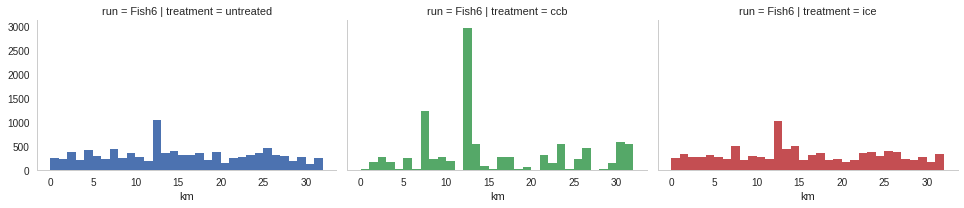

In [247]:
fg = sns.FacetGrid(df, col='treatment', row='run', hue='treatment', size=3, aspect=1.5)
fg = fg.map(plt.hist, 'km', bins=range(nclust + 1))

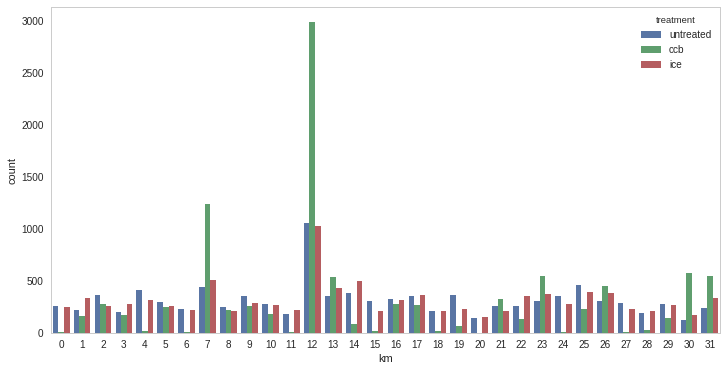

In [248]:

fig = plt.figure(figsize=(12,6))
cp = sns.countplot(x='km', hue='treatment', data=df)


(30000, 32, 32, 1)


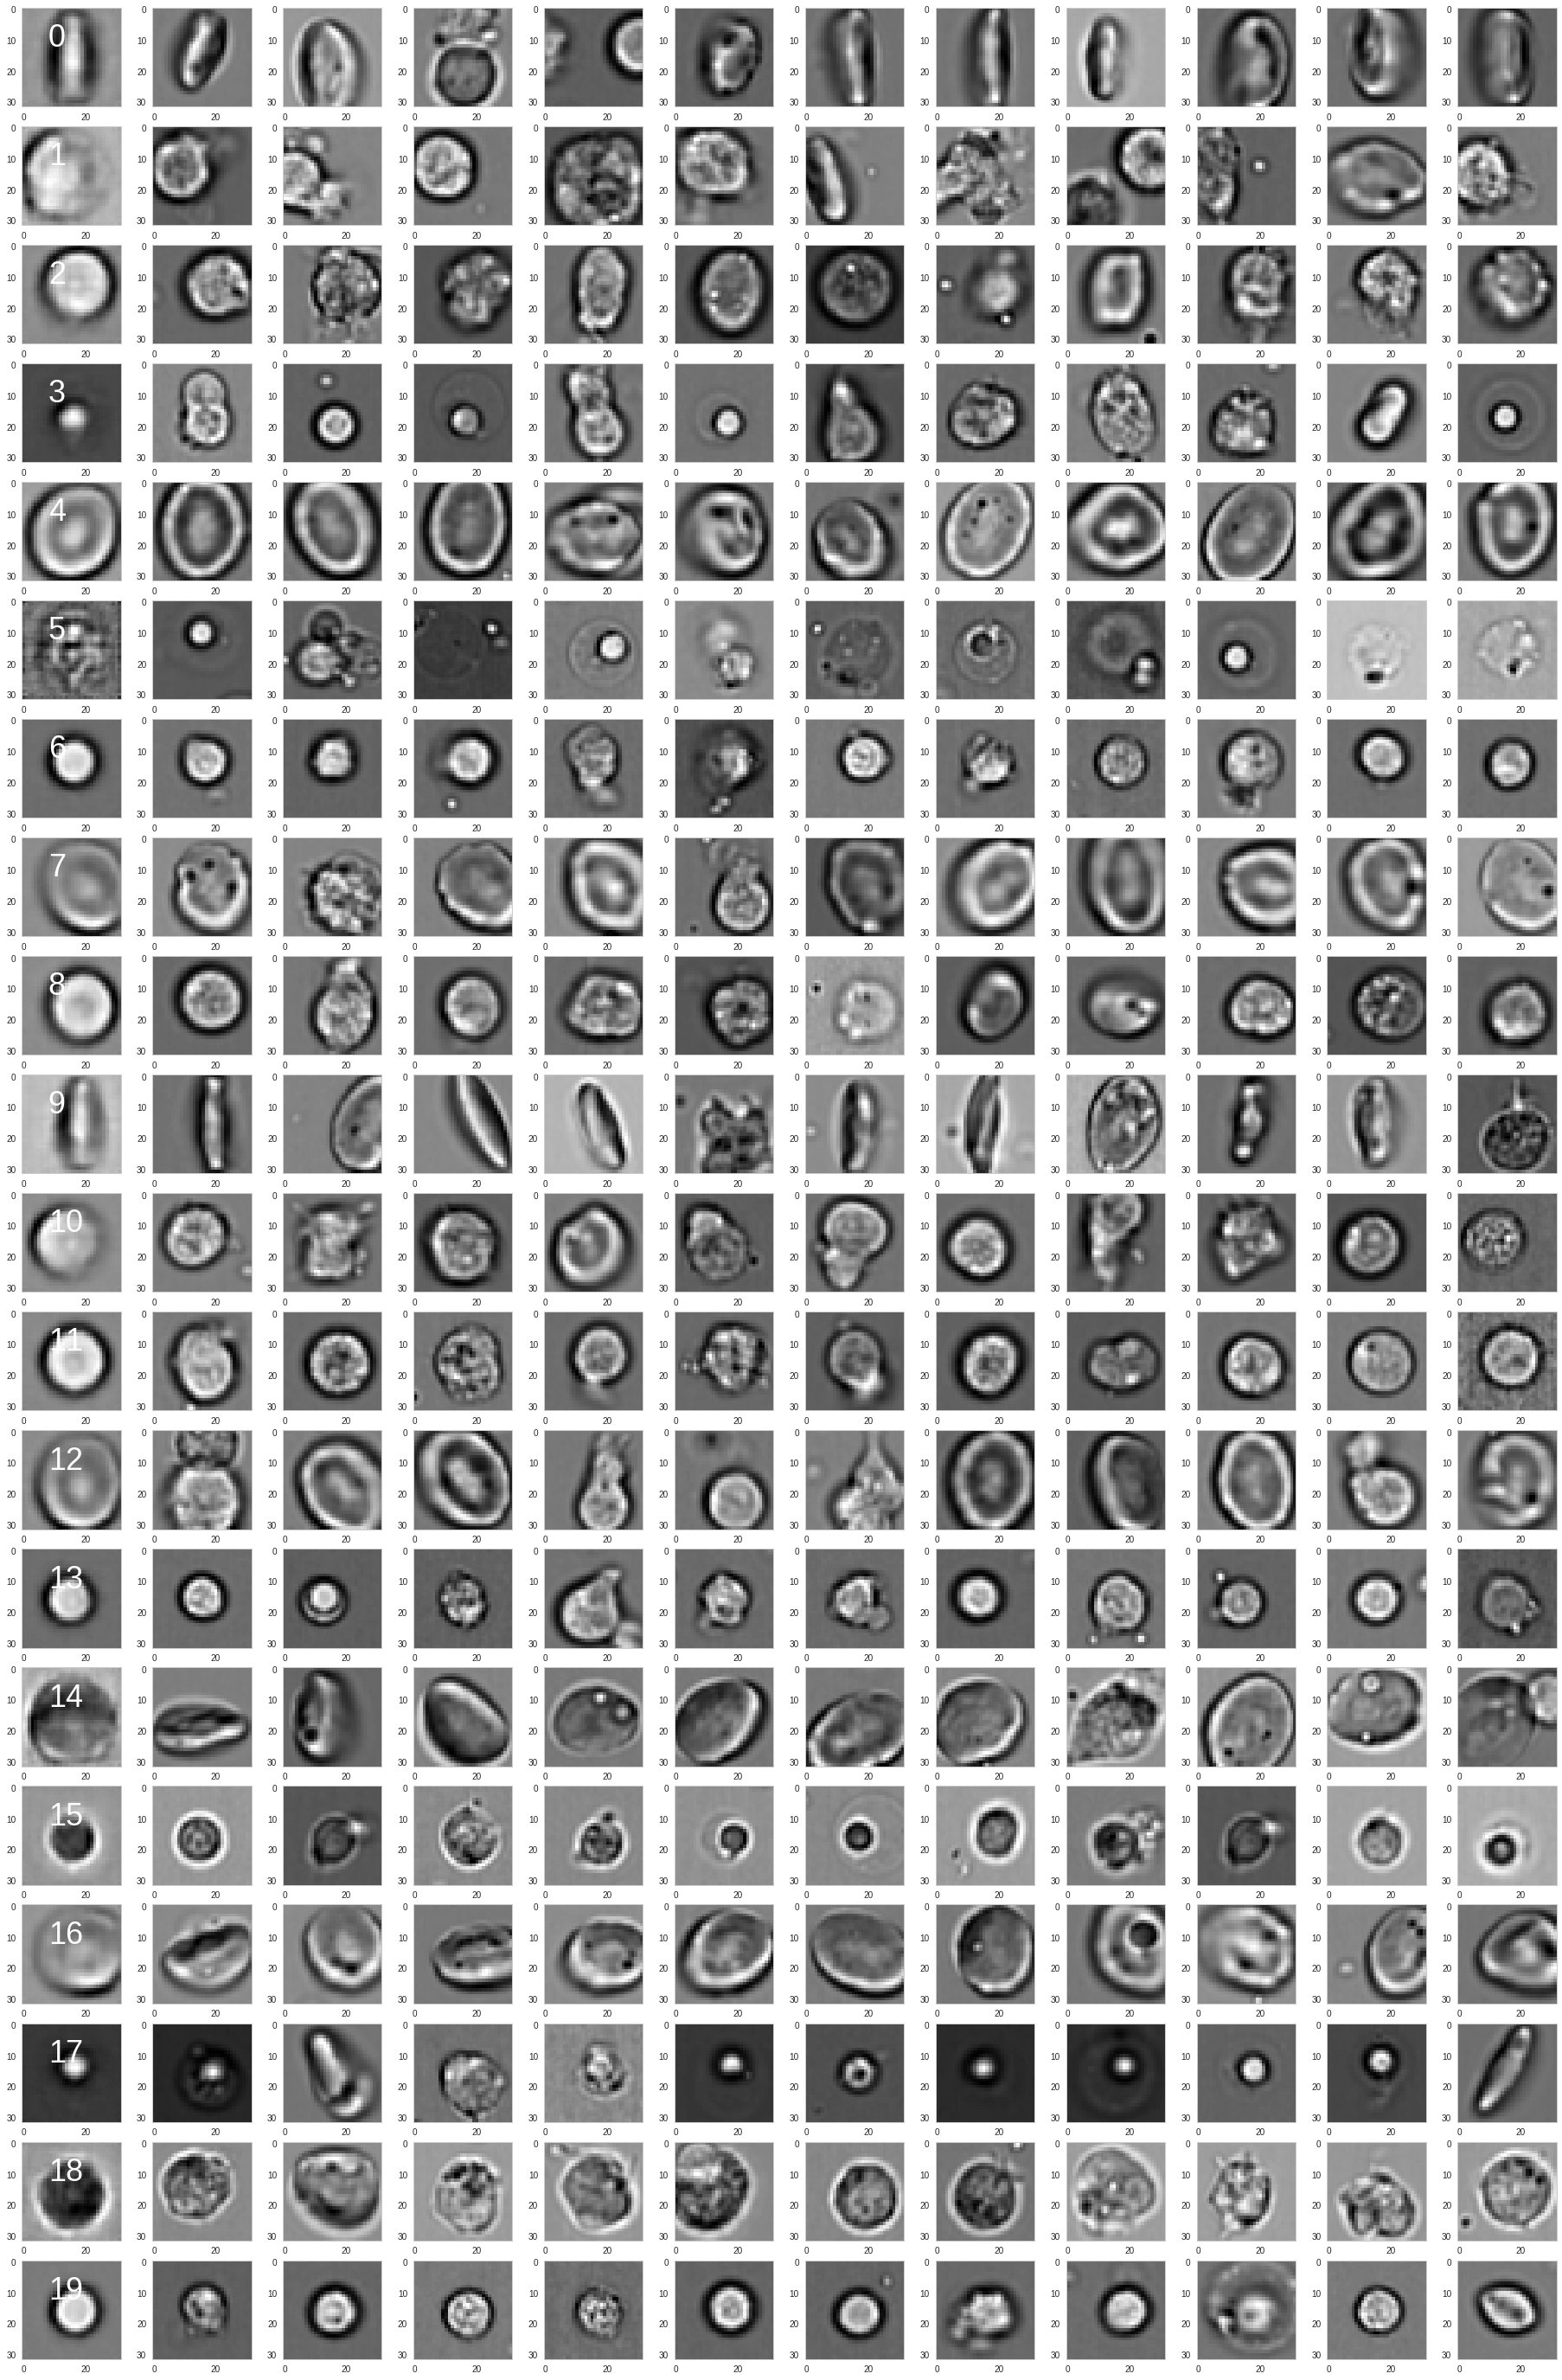

In [235]:
ximages = vv
print(ximages.shape)

nk = nclust
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in range(nk):
    #row = ximages[km == k]
    rowdf = df[df['km'] == k]
    inum = list(rowdf.index)
    gk = g_all[km == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 12, counter)
    plt.imshow(resav.squeeze(), cmap='gray')
    plt.text(8, 12,str(k), fontsize=36, color='white')
    counter += 1
    for i in range(11):
        plt.subplot(nk, 12, counter)
        counter += 1
        try:
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            #plt.text(5, 5,str(df.iloc[rnd]['id']), fontsize=20, color='black')
            #print(rnd, df.iloc[rnd]['mmfile'])
        except:
            plt.imshow(np.zeros((64,64)))

###  Show results of clustering using Agglomerative Clustering

Each row is a cluster found using the [Agglomerative Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

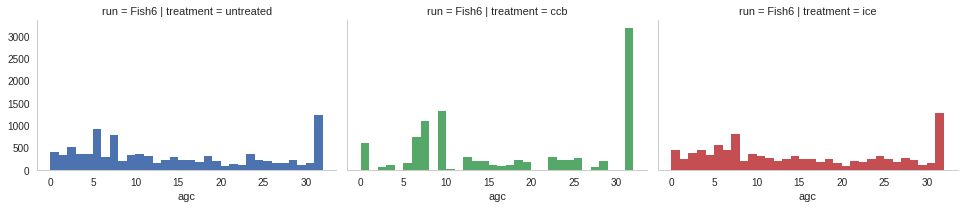

In [249]:
df['agc'] = agc
fg = sns.FacetGrid(df, col='treatment', row='run', hue='treatment', size=3, aspect=1.5)
fg = fg.map(plt.hist, 'agc', bins=range(nclust + 1))

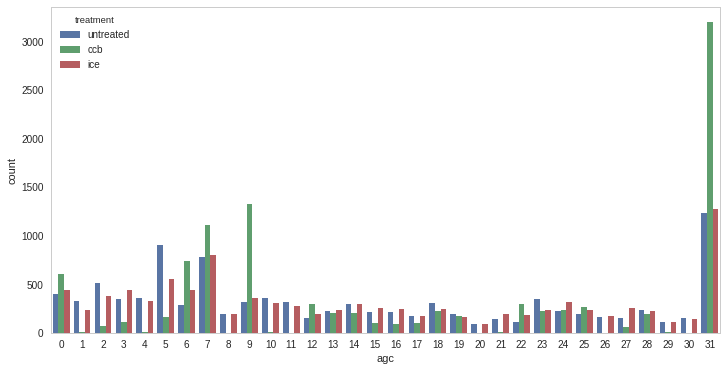

In [250]:

fig = plt.figure(figsize=(12,6))
cp = sns.countplot(x='agc', hue='treatment', data=df)


0 1441
1 564
2 956
3 905
4 691
5 1618
6 1459
7 2684
8 390
9 2007
10 664
11 594
12 636
13 666
14 800
15 566
16 548
17 438
18 776
19 523
20 187
21 339
22 584
23 803
24 771
25 695
26 338
27 470
28 650
29 231
30 302
31 5704


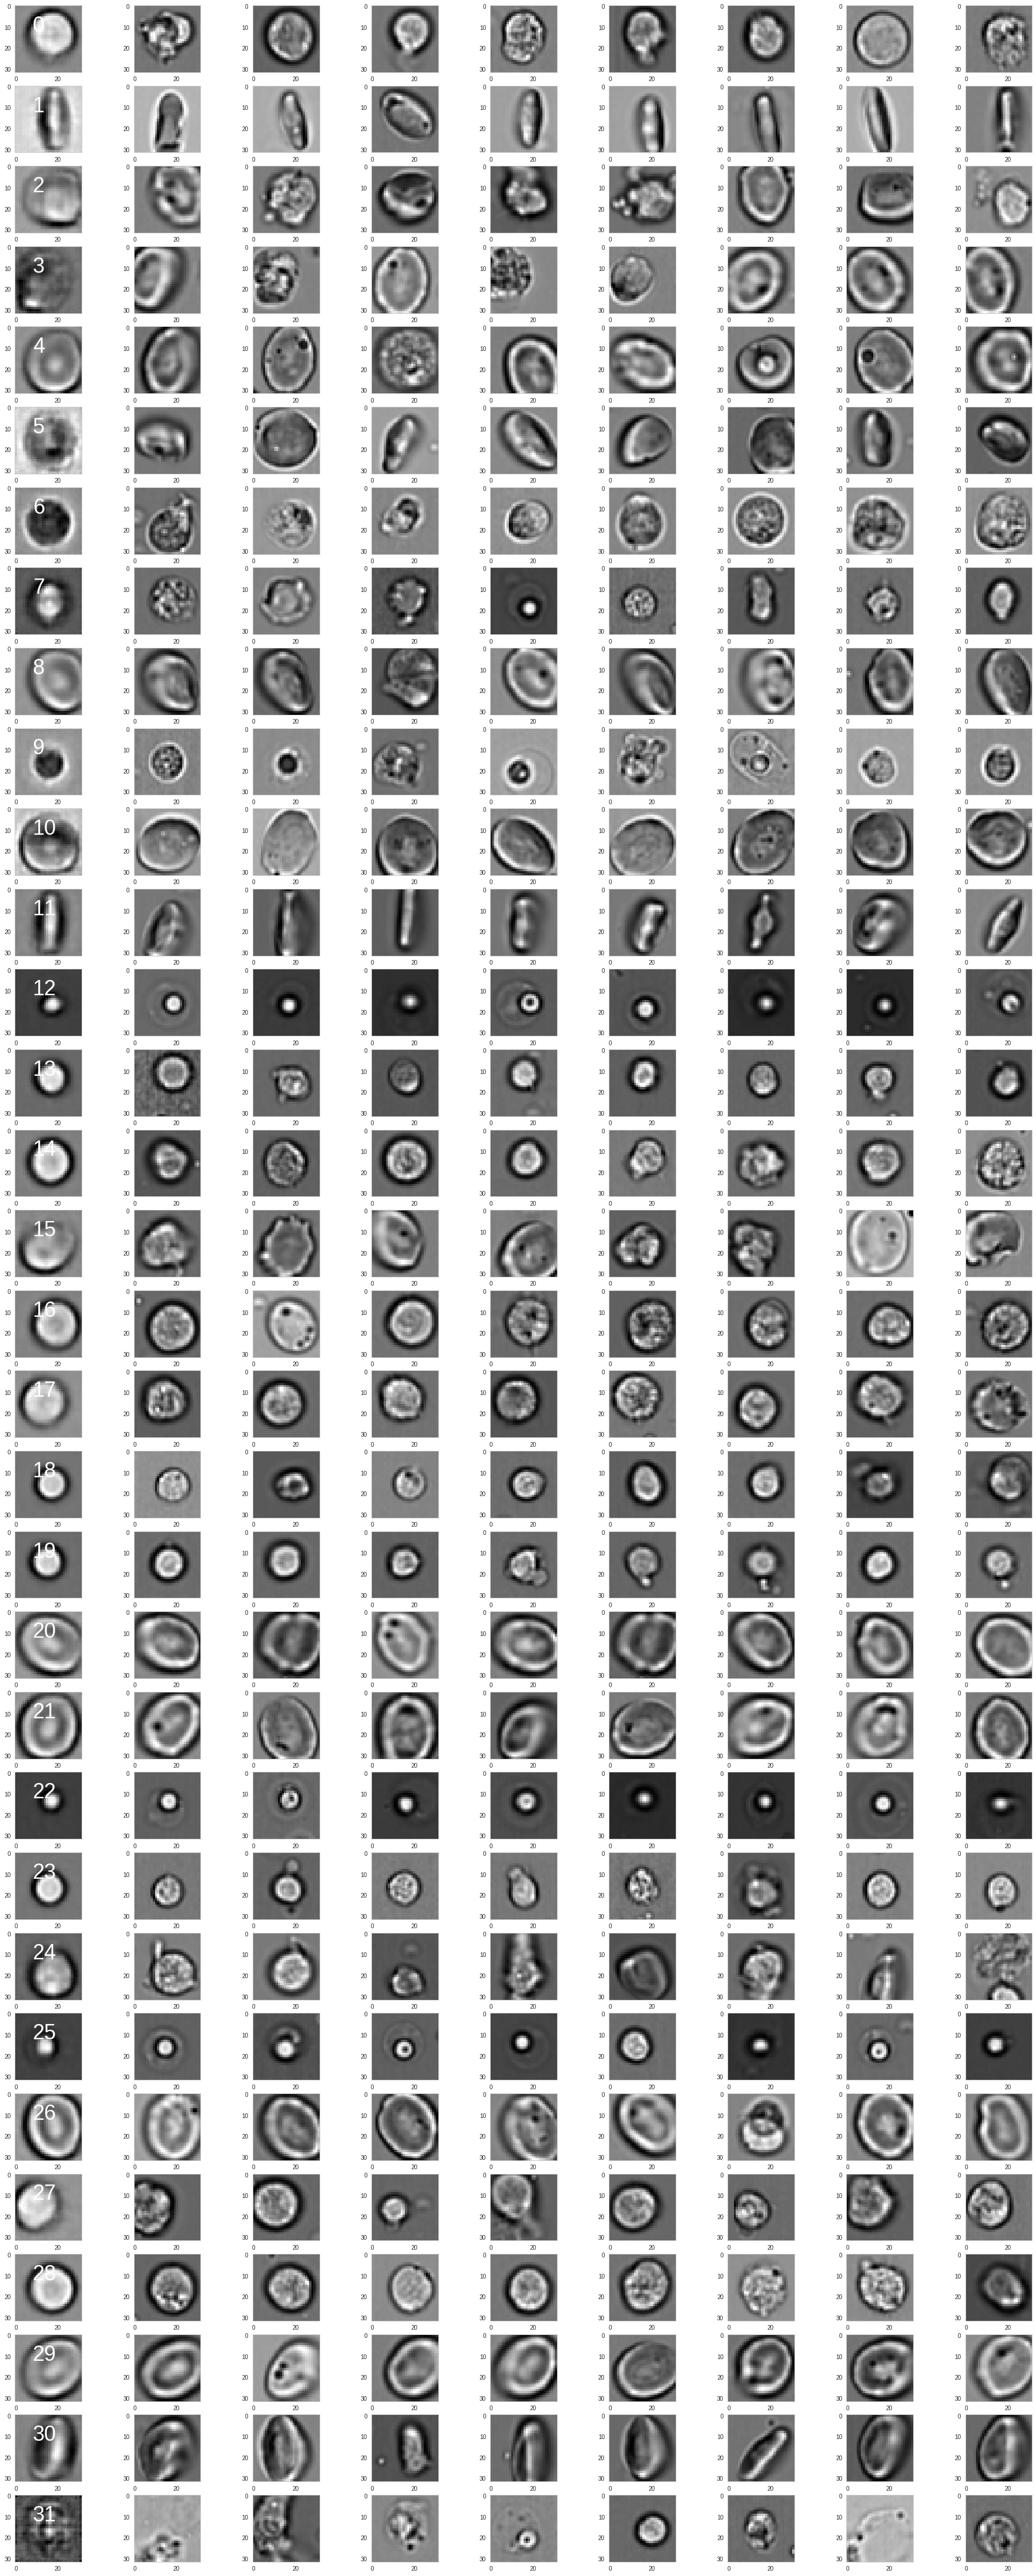

In [253]:
nk = nclust
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in range(nk):
    #row = ximages[agc == k]
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    print(k, len(rowdf))
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 9, counter)
    plt.imshow(resav.squeeze(), cmap='gray')
    plt.text(8, 12,str(k), fontsize=36, color='white')
    counter += 1
    for i in range(8):
        plt.subplot(nk, 9, counter)
        counter += 1
        try:
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            #plt.text(8, 12,str(rnd), fontsize=24, color='white')
        except:
            plt.imshow(np.zeros((64,64)))

-------------------------------------------------------------------------

(908, 32, 32, 1)


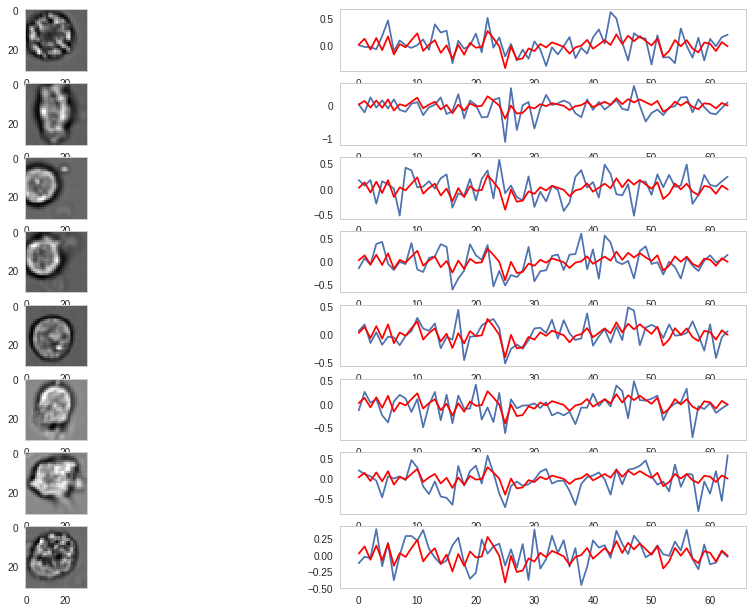

In [239]:
tn = 11
images4 = ximages[agc == tn]
g4 = g_all[agc == tn]
plt.figure(figsize=(16,12))
print(images4.shape)

gtest = np.mean(g4, axis=0)
gtest = np.expand_dims(gtest.squeeze(), axis=0)
res = sess.run(sdd, feed_dict={enc:gtest})

gav = np.mean(g_all, axis=0)
gav = np.expand_dims(gav.squeeze(), axis=0)
resav = sess.run(sdd, feed_dict={enc:gav})

ppi = 0
for i in range(8):
    ix = np.random.randint(0, len(g4))
    plt.subplot(9,2,i*2 + 1)
    plt.imshow(images4[ix,:,:,0], cmap='gray')
    plt.subplot(9,2, i*2 + 2)
    plt.plot(g4[ix,:])
    plt.plot(gtest.squeeze(), c='r')
    ppi += 2

#plt.subplot(9,2, ppi+ 1 )
#plt.imshow(res.squeeze())
#plt.subplot(9,2, ppi + 2)
#plt.plot(gtest.squeeze())
#plt.subplot(6,2, ppi + 3)
#plt.imshow(resav.squeeze())
#plt.subplot(6,2, ppi + 4)
#plt.plot(gav.squeeze())


In [240]:
from sklearn.manifold import TSNE
print(g_all.shape)
geez = list()
ceez = list()
cindex = 0
for i in range(nk):
    gna = g_all[agc == i]
    ca = cindex #np.array(clist[cindex])
    cna = np.repeat([i], gna.shape[0], axis=0)
    geez.append(gna)
    ceez.append(cna)
    cindex += 1
# c3 = gn3.shape[0]*(1, 0, 0)
# c6 = gn3.shape[0]*(0, 1, 0)
# c10 = gn3.shape[0]*(0, 0, 1)
gn = np.concatenate(geez)
cn = np.concatenate(ceez)

# cn = np.concatenate((c3, c6, c10))
print(gn.shape)
g_emb = TSNE(n_components=2,perplexity=50, learning_rate=1000).fit_transform(g_all.astype(np.float64))
print(g_emb.shape)

(30000, 64)
(30000, 64)
(30000, 2)


/home/cjw/anaconda3/envs/deep/lib/python3.6/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


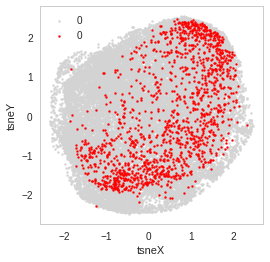

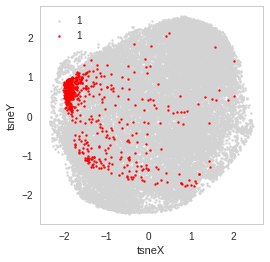

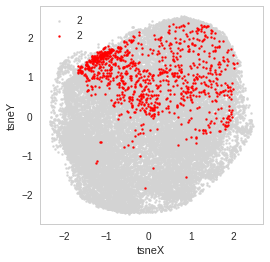

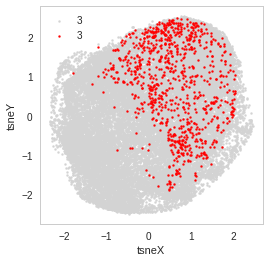

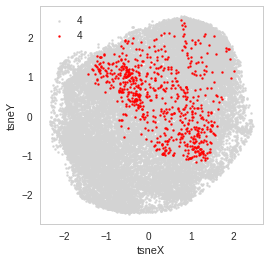

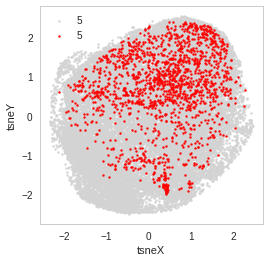

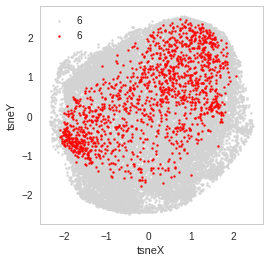

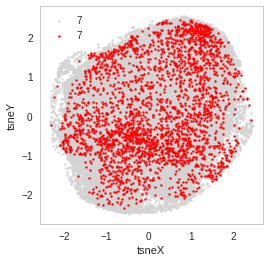

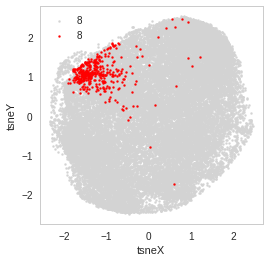

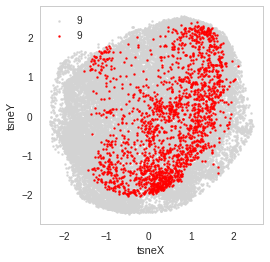

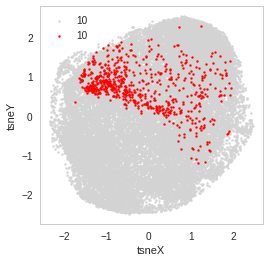

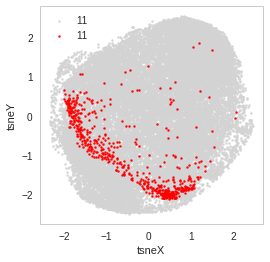

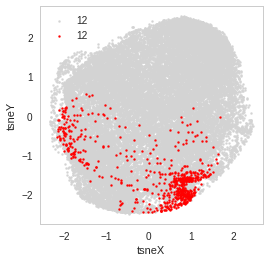

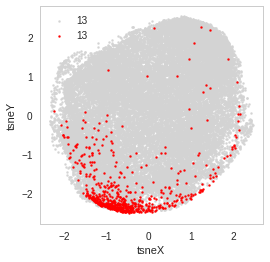

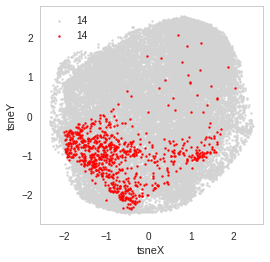

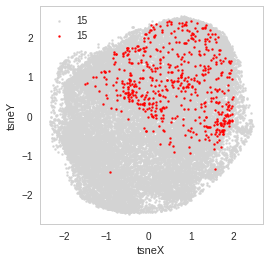

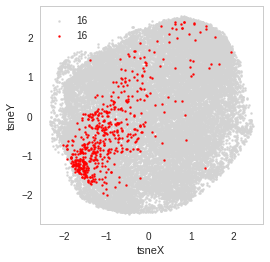

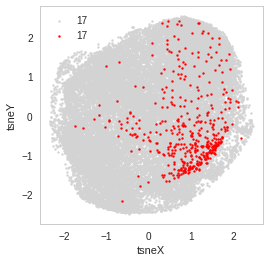

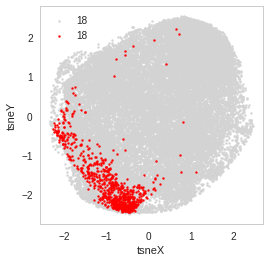

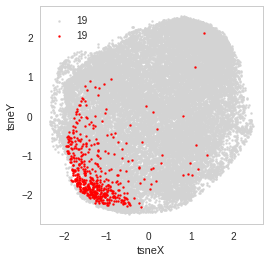

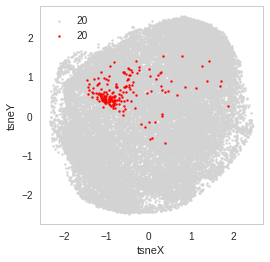

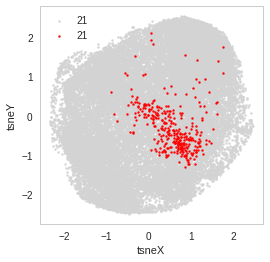

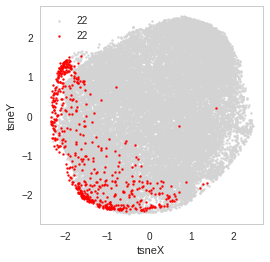

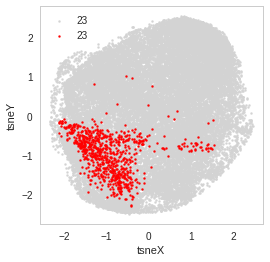

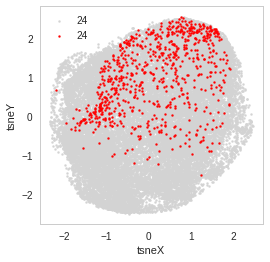

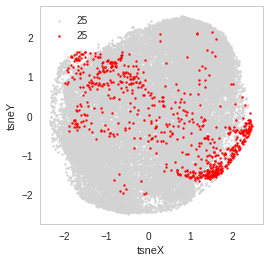

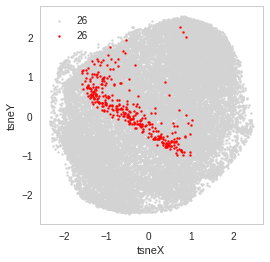

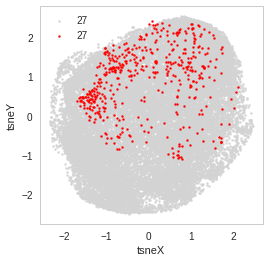

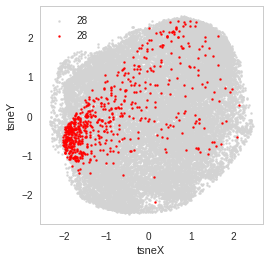

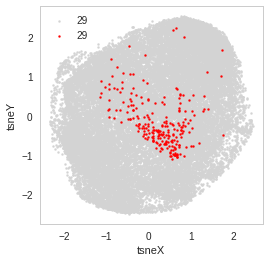

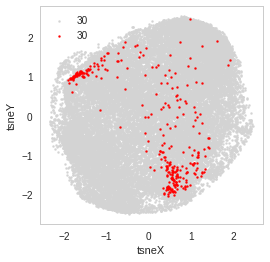

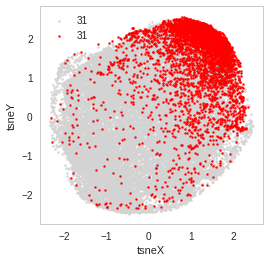

In [251]:
df['tsneX'] = g_emb[:,0]
df['tsneY'] = g_emb[:,1]

cs = ['black', 'gray', 'navy', 'blue',
      'slateblue', 'darkgreen', 'green', 'greenyellow',
     'gold', 'saddlebrown', 'salmon', 'orange']
ax = None

coi1 =  1
coi2 =  11
for i in range(nclust):
        ax = df[df['agc'] != i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color='lightgray', figsize=(4,4))
        df[df['agc'] == i].plot.scatter('tsneX', 'tsneY', label=i, s=4, color='red', ax = ax)
   
           
#df[df['agc'] == coi1].plot.scatter('tsneX', 'tsneY', label=i, s=4, color='red', ax = ax)
#df[df['agc'] == coi2].plot.scatter('tsneX', 'tsneY', label=i, s=4, color='green', ax = ax)

(30000,)
(28559,)
0
(30000,)
[0]


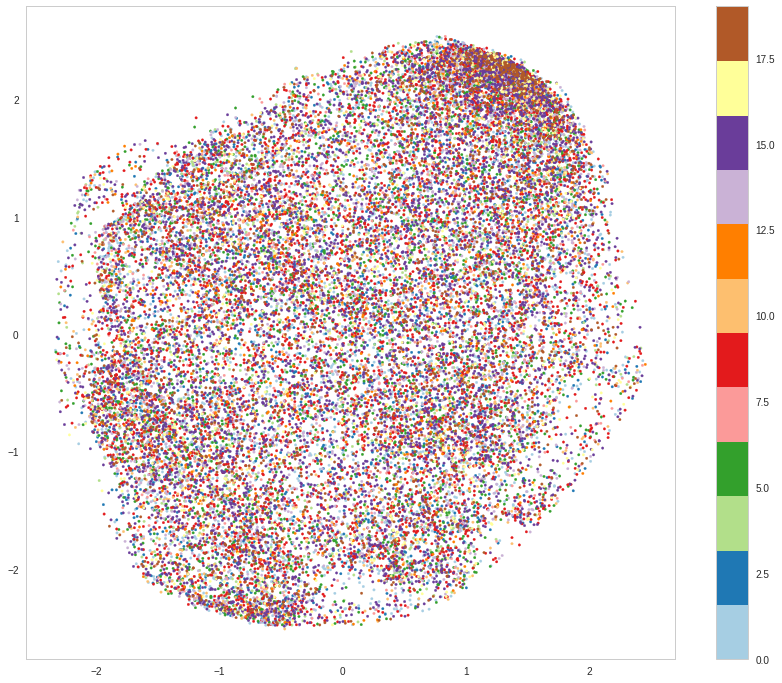

In [252]:

print(agc.shape)
print(agc[agc !=0].shape)
clist3 = clist*3
#cykm = [clist[z] for z in km[km !=4]]
#cya = [clist3[z] for z in agc
print(ceez[0][0])
print(cn.shape)
#from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(32,12))
# plt.subplot(121)
# plt.scatter(g_emb[:,0], g_emb[:,1], s=3, c=cykm)
cm = plt.cm.get_cmap('RdYlBu')
plt.subplot(122)

print(np.arange(0,1,len(g_emb)))
ax = plt.scatter(g_emb[:,0], g_emb[:,1], s=6, c=cn, cmap='Paired')
cbar = plt.colorbar()

In [43]:
gfit.shape

(12000, 8)

In [243]:
for i in range(gfit.shape[1]):
    df['pca' + str(i)] = gfit[:,i]
    
df.head()

index  column   fid  field             file     id              mmfile  \
0   9972       0  9972      0  Fish6_Untreated   9972  Fish6_Untreated.mm   
1  21252       0  1252      0        Fish6_CCB  21252        Fish6_CCB.mm   
2  28187       0  8187      0        Fish6_CCB  28187        Fish6_CCB.mm   
3  18573       0  8573      0        Fish6_ICE  18573        Fish6_ICE.mm   
4  20724       0   724      0        Fish6_CCB  20724        Fish6_CCB.mm   

   plate  row  well    ...        tsneX     tsneY      pca0      pca1  \
0      0    0     0    ...    -0.164244  1.041941  0.567416 -0.673920   
1      0    0     0    ...     0.663435  2.058252  0.656887 -0.107388   
2      0    0     0    ...    -1.287359 -1.497638  1.863986  0.837794   
3      0    0     0    ...     0.773059 -0.744575 -0.810076  0.005279   
4      0    0     0    ...     0.724134  1.805773 -0.369700 -0.330812   

       pca2      pca3      pca4      pca5      pca6      pca7  
0 -0.461205  0.879949 -0.268286  1.489695  0.827260 -0.598606  
1 -0.006521 -0.030275  0.622781  0.227355  0.311184 -0.419369  
2 -2.356197  0.892689 -2.406071  1.722695  0.539936 -0.609803  
3  0.696187 -0.694380  3.043282  0.897813  0.911998  0.982770  
4 -0.106227  0.731452 -0.633792  0.398527 -0.235629  0.036136  

[5 rows x 26 columns]

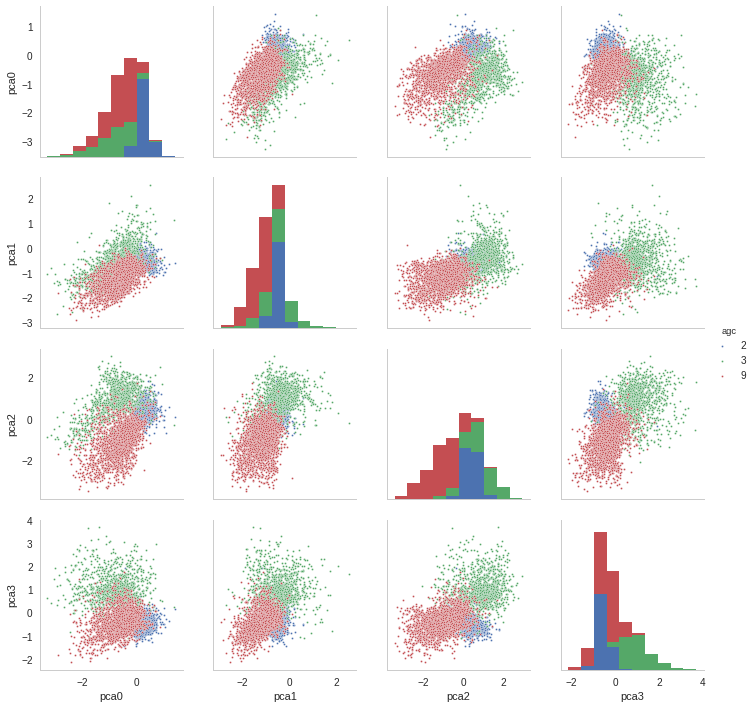

In [244]:
sns.pairplot(df[df['agc'].isin([2,3,9])], hue='agc', vars=['pca0', 'pca1', 'pca2', 'pca3'], plot_kws=dict(s=4))

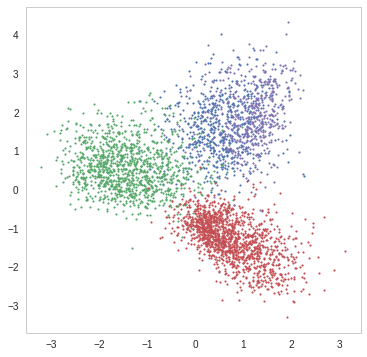

In [37]:

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
sc = ax.scatter(gfit[agc == 0][:,0], gfit[agc == 0][:,1], s=3)#, c=cn, cmap='Dark2')
sc = ax.scatter(gfit[agc == 1][:,0], gfit[agc == 1][:,1], s=3)#, c=cn, cmap='Dark2')
sc = ax.scatter(gfit[agc == 2][:,0], gfit[agc == 2][:,1], s=3)#, c=cn, cmap='Dark2')
# sc = ax.scatter(gfit[agc == 3][:,0], gfit[agc == 3][:,1], s=3)#, c=cn, cmap='Dark2')
# sc = ax.scatter(gfit[agc == 4][:,0], gfit[agc == 4][:,1], s=3)#, c=cn, cmap='Dark2')
# sc = ax.scatter(gfit[agc == 5][:,0], gfit[agc == 5][:,1], s=3)#, c=cn, cmap='Dark2')
# sc = ax.scatter(gfit[agc == 6][:,0], gfit[agc == 6][:,1], s=3)#, c=cn, cmap='Dark2')
sc = ax.scatter(gfit[agc == 7][:,0], gfit[agc == 7][:,1], s=3)#, c=cn, cmap='Dark2')


In [ ]:
from pandas.tools.plotting import andrews_curves
